## Libraries

In [3]:
from PIL import Image
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
import torch

torch.cuda.empty_cache()

## Loading the model

In [4]:
model_id = "llava-hf/llava-1.5-7b-hf"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
).to(0)

processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Test on a random image from the generated ones

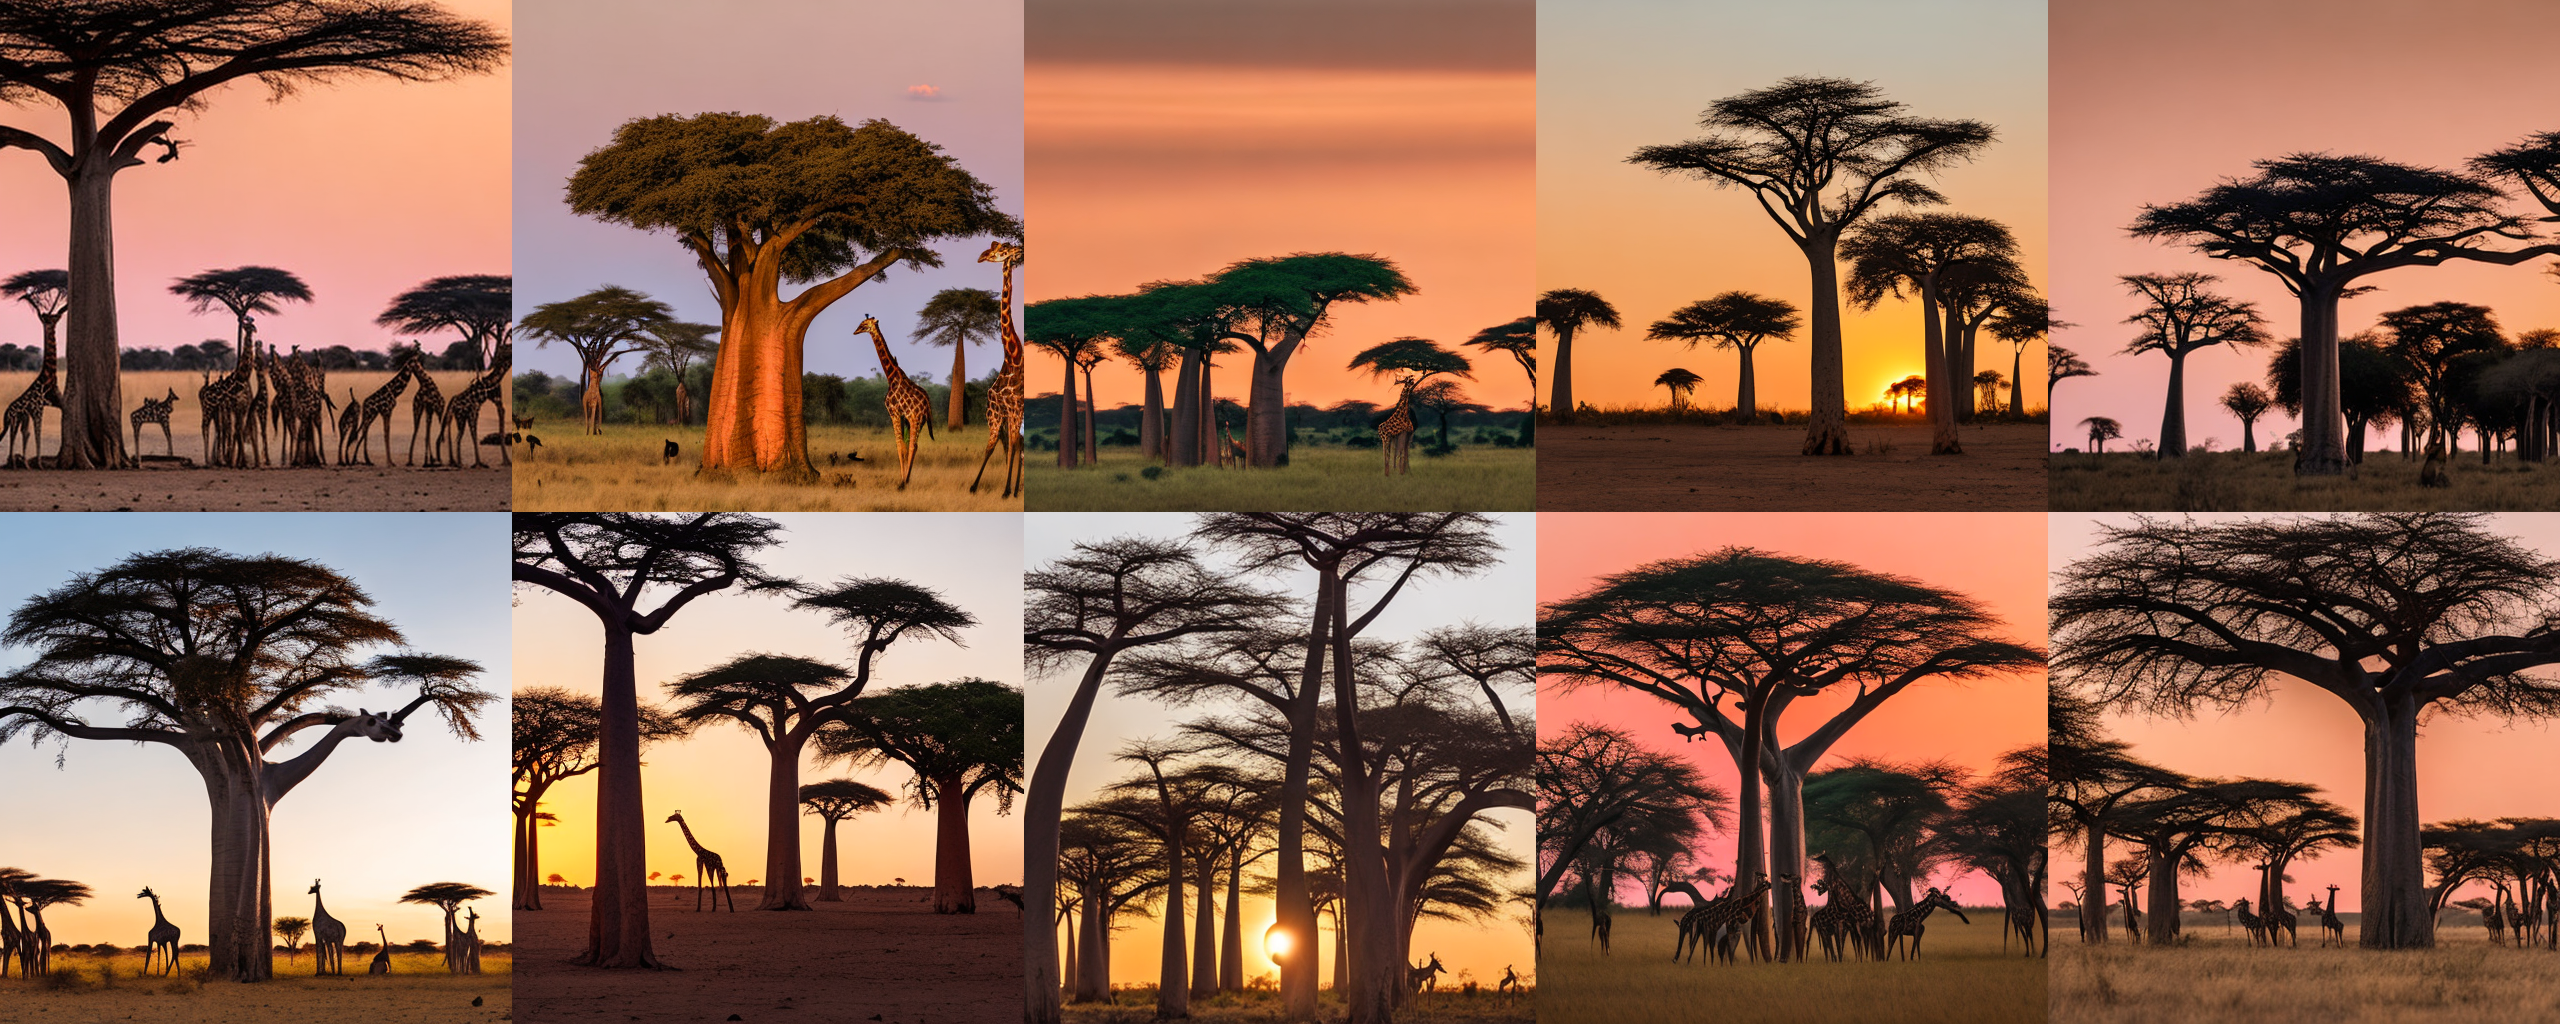

In [5]:
import random
import os

image_files = [f for f in os.listdir('../generative_images2/') if f.endswith(('.png', '.jpg', '.jpeg'))]

selected_image = random.choice(image_files)
image = Image.open(os.path.join('../generative_images2/', selected_image))
#print(selected_image)

image = Image.open(os.path.join('../generative_images2/', '114_giraffe.png'))
selected_image = '114_giraffe.png'
image

## subdivide the grouped images into single ones

In [6]:
def extract_images_from_grid(grid, rows, cols):
    images = []
    for i in range(rows):
        for j in range(cols):
            box = (j * grid.width // cols, i * grid.height // rows, (j + 1) * grid.width // cols, (i + 1) * grid.height // rows)
            images.append(grid.crop(box))
    return images

## LlaVa interpretation

In [9]:
image_number = selected_image.split('_')[0]
class_name = selected_image.split('_')[1].split('.')[0]

prompts_file_path = '../generated_prompts2.txt'
with open(prompts_file_path, 'r', encoding='utf-8') as prompts_file:
    lines = prompts_file.readlines()
    if int(image_number) < len(lines):
        prompt_line = lines[int(image_number)-1].strip()
        description = prompt_line.split(';')[1].strip()
        print(description)

extracted_imgs = extract_images_from_grid(image, 2, 5)

Wide shot of a giraffe herd gathered around a tree, Giraffes socializing, Sunset, Background: Large baobab tree and red and orange hues in the sky, sharp, photography, Fujifilm X-T2, 18-55mm, f/6, natural lighting, RAW photo.


In [11]:
SYST_PROMPT = f"I need you to scrutinize and very carefully examine the image, pay attention to the finest details, and make use of any relevant information or small abnormalities."

prompt = f"""USER: <image>\n{SYST_PROMPT}\n
1. Does this image look realistic, considering lighting, shadows, and reflections?
2. Are there any subtle, unexpected patterns or behaviors in the image that might not be immediately noticeable?
3. can you clearly see {class_name} in the image?
4. (if the answer of the previous question is 'No' answer 'Nan' to this question) Considering specific details like {class_name} posture, head and body shape, number of legs and form and the surroundings view, does the image look normal?
5. (if the answer of the previous question is 'No' answer 'Nan' to this question) If {class_name} is present, does it exhibit realistic and natural behavior?
6. (if the answer of the previous question is 'No' answer 'Nan' to this question) Are there any other objects or elements in the image that might be mistakenly identified as {class_name}?
7. (if response to question 3. is 'No' answer 'Nan' to this question) Does the representation of {class_name} in the image maintain anatomical accuracy (e.g., correct number of legs, tail, head)?
8. Do the colors in the image accurately match the description in the PROMPT {description}, including subtle variations and shades?
9. Can you identify any deviations or abnormalities in the image that might be less obvious but still significant?
10. Does the overall composition and arrangement of elements in the image fully align with the given PROMPT: {description}?

For each question, answer 'yes' or 'no' or 'nan' accordingly. If there are discrepancies, provide a brief description of the issues.\n\nASSISTANT: \n"""

highest_score_indices = []

for i in range(10):
    inputs = processor(prompt, extracted_imgs[i], return_tensors='pt').to(0)
    output = model.generate(**inputs, max_new_tokens=512*2)
    response_ = processor.decode(output[0][2:], skip_special_tokens=False)
    answers_section_ = response_.split('ASSISTANT:')[1].split('</s>')[0].strip()
    answers = [ans.strip().split(' ')[1].lower() for ans in answers_section_.split('\n') if ans.strip()]  # Extracting individual answers
    
    # Calculate scores for each question
    scores = [1 if i == 1 or (i in [3, 4, 5, 6, 7, 8, 10] and ans == 'yes') or (i == 9 and ans == 'no') else -1 if i == 2 and ans == 'yes' else 0 for i, ans in enumerate(answers, start=1)]
    
    total_score = sum(scores)

    print(f'image {i+1}: {total_score}') #if response with prompt: print(processor.decode(output[0][2:], skip_special_tokens=False))
    
    if not highest_score_indices or total_score > highest_score_indices[0][1]:
        highest_score_indices = [(i, total_score)]  
    elif total_score == highest_score_indices[0][1]:
        highest_score_indices.append((i, total_score)) 

    #print(scores)
    print("-----------------------")


image 1: 8
-----------------------
image 2: 7
-----------------------
image 3: 8
-----------------------
image 4: 4
-----------------------
image 5: 8
-----------------------
image 6: 8
-----------------------
image 7: 8
-----------------------
image 8: 8
-----------------------
image 9: 8
-----------------------
image 10: 8
-----------------------


In [12]:
indices = [index for index, _ in highest_score_indices]
print(indices)

[0, 2, 4, 5, 6, 7, 8, 9]


In the form of Yes and No responses it looks like this:

In [13]:
for i in range(10):
    inputs = processor(prompt, extracted_imgs[i], return_tensors='pt').to(0)
    output = model.generate(**inputs, max_new_tokens=512*2)
    response_ = processor.decode(output[0][2:], skip_special_tokens=False)
    answers_section_ = response_.split('ASSISTANT:')[1].split('</s>')[0].strip()
    answers = [ans.strip() for ans in answers_section_.split('\n') if ans.strip()]  # Extracting individual answers

    print(answers) #if response with prompt: print(processor.decode(output[0][2:], skip_special_tokens=False))
    print("-----------------------")

['1. Yes', '2. No', '3. Yes', '4. Yes', '5. Yes', '6. No', '7. Yes', '8. Yes', '9. No', '10. Yes']
-----------------------
['1. Yes', '2. Yes', '3. Yes', '4. Yes', '5. Yes', '6. No', '7. Yes', '8. Yes', '9. No', '10. Yes']
-----------------------
['1. Yes', '2. No', '3. Yes', '4. Yes', '5. Yes', '6. No', '7. Yes', '8. Yes', '9. No', '10. Yes']
-----------------------
['1. Yes', '2. No', '3. No', '4. No', '5. No', '6. No', '7. No', '8. Yes', '9. No', '10. Yes']
-----------------------
['1. Yes', '2. No', '3. Yes', '4. Yes', '5. Yes', '6. No', '7. Yes', '8. Yes', '9. No', '10. Yes']
-----------------------
['1. Yes', '2. No', '3. Yes', '4. Yes', '5. Yes', '6. No', '7. Yes', '8. Yes', '9. No', '10. Yes']
-----------------------
['1. Yes', '2. No', '3. Yes', '4. Yes', '5. Yes', '6. No', '7. Yes', '8. Yes', '9. No', '10. Yes']
-----------------------
['1. Yes', '2. No', '3. Yes', '4. Yes', '5. Yes', '6. No', '7. Yes', '8. Yes', '9. No', '10. Yes']
-----------------------
['1. Yes', '2. No',


0: 640x640 7 giraffes, 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


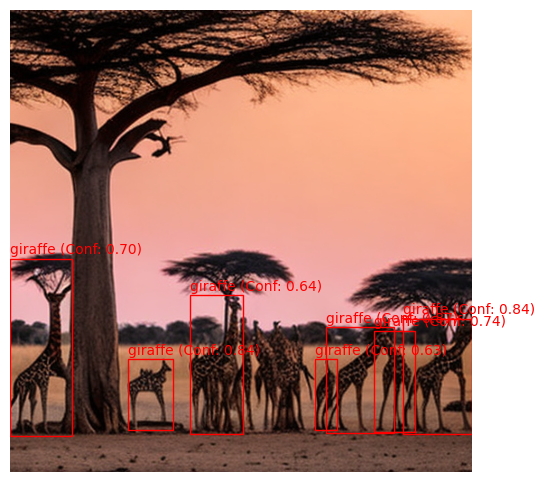


0: 640x640 2 giraffes, 13.1ms
Speed: 1.8ms preprocess, 13.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


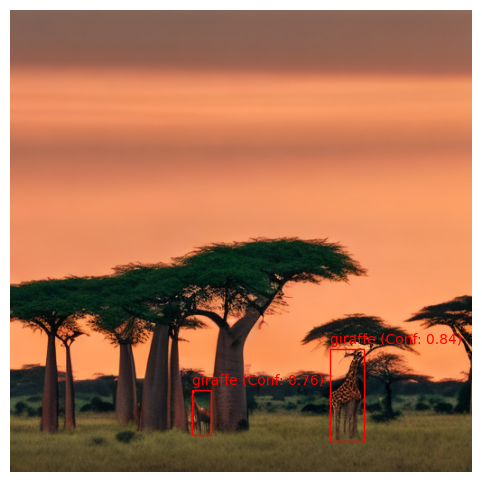


0: 640x640 (no detections), 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 giraffes, 13.1ms
Speed: 2.1ms preprocess, 13.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


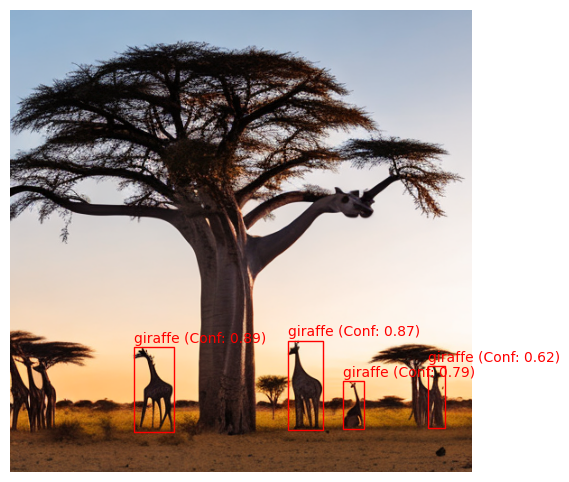


0: 640x640 1 giraffe, 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


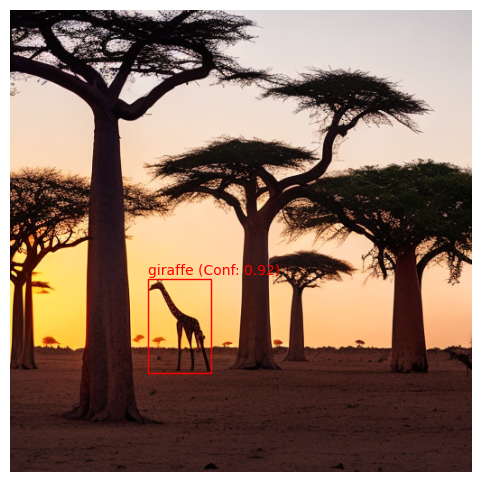


0: 640x640 (no detections), 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 giraffes, 13.1ms
Speed: 1.7ms preprocess, 13.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


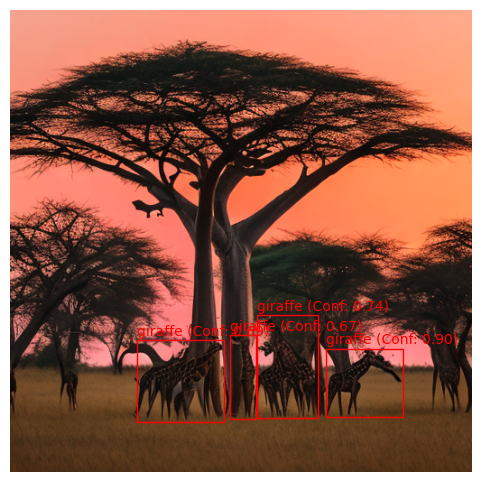


0: 640x640 2 giraffes, 14.0ms
Speed: 2.5ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


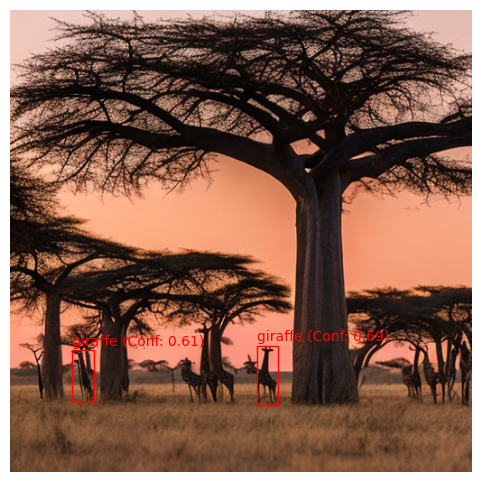

Image index with the best confidence value:
6


In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO

best_confidence_index = None
best_confidence_value = 0.0

model = YOLO("yolov8x-worldv2.pt") 
model.set_classes([class_name])

for i in indices:
    res = model.predict(extracted_imgs[i], conf=0.5)
    
    if res[0].boxes.xyxy.cpu().numpy().any():
        fig, ax = plt.subplots(figsize=(8, 6))

        for j, prediction in enumerate(res):
            boxes = prediction.boxes.xyxy.cpu().numpy()
            confidences = prediction.boxes.conf.cpu().numpy()

            for box, confidence in zip(boxes, confidences):
                x, y, w, h = box[:4]

                rect = patches.Rectangle((x, y), w - x, h - y, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

                ax.text(x, y - 5, f"{class_name} (Conf: {confidence:.2f})", color='r')

                if confidence > best_confidence_value:
                    best_confidence_value = confidence
                    best_confidence_index = i

        ax.imshow(extracted_imgs[i])
        ax.axis('off')
        plt.show() 

print("Image index with the best confidence value:")
print(best_confidence_index)


In [17]:
if best_confidence_index is not None:
    save_path = "./optimal_pairs4/"
    os.makedirs(save_path, exist_ok=True)  
    save_path = os.path.join(save_path, f"image_{best_confidence_index}.png")
        
    extracted_imgs[best_confidence_index].save(save_path)

    print(f"Image saved at: {save_path}")
else:
    print("No image to save.")

Image saved at: ./optimal_pairs4/image_6.png
